In [12]:
import pandas as pd 
import numpy as np 

def load_parquet_data(file_path):
    """
    Load cryptocurrency data from a parquet file
    
    Args:
        file_path: Path to the parquet file
        
    Returns:
        pd.DataFrame: DataFrame with cryptocurrency data
    """
    try:
        df = pd.read_parquet(file_path)
        print(f"Successfully loaded data from {file_path}")
        print(f"Shape: {df.shape} (rows, columns)")
        
        if 'symbol' in df.columns:
            # Long format
            print(f"Format: Long format")
            print(f"Date range: {df['open_time'].min()} to {df['open_time'].max()}")
            symbols = df['symbol'].unique()
            print(f"Contains data for {len(symbols)} cryptocurrencies")
        else:
            # Wide format
            print(f"Format: Wide format")
            print(f"Date range: {df.index.min()} to {df.index.max()}")
            symbols = list(set([col.split('_')[0] for col in df.columns if '_' in col]))
            print(f"Contains data for {len(symbols)} cryptocurrencies")
        
        return df
    except Exception as e:
        print(f"Error loading parquet file: {e}")
        return None

def explore_directory_structure(base_path, max_depth=3):
    """
    Explore the directory structure to understand how files are organized
    
    Args:
        base_path: Base path to explore
        max_depth: Maximum depth to explore
    """
    base_path = Path(base_path)
    
    def _explore(path, depth, prefix=""):
        if depth > max_depth:
            return
        
        items = list(path.iterdir())
        items.sort()
        
        for i, item in enumerate(items):
            is_last = i == len(items) - 1
            connector = "└── " if is_last else "├── "
            
            print(f"{prefix}{connector}{item.name}")
            
            if item.is_dir() and depth < max_depth:
                next_prefix = prefix + ("    " if is_last else "│   ")
                _explore(item, depth + 1, next_prefix)
    
    print(f"Directory structure of {base_path}:")
    _explore(base_path, 1)

In [13]:
path = '/Users/mouyasushi/Desktop/quantDevops/Research/Alpha-Research/kline/binance/all_crypto_data_1d_long.parquet'

agg_df = load_parquet_data(path)

Successfully loaded data from /Users/mouyasushi/Desktop/quantDevops/Research/Alpha-Research/kline/binance/all_crypto_data_1d_long.parquet
Shape: (31878, 11) (rows, columns)
Format: Long format
Date range: 2021-01-01 00:00:00 to 2025-02-26 00:00:00
Contains data for 21 cryptocurrencies


In [14]:
agg_df

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,symbol
0,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,1.411901e+07,AAVEUSDT
1,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,1.219980e+07,AAVEUSDT
2,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,1.964500e+07,AAVEUSDT
3,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,5.291774e+07,AAVEUSDT
4,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,4.365867e+07,AAVEUSDT
...,...,...,...,...,...,...,...,...,...,...,...
31873,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,4.143709e+06,XTZUSDT
31874,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,2.258186e+06,XTZUSDT
31875,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,7.900364e+06,XTZUSDT
31876,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,1.081920e+07,XTZUSDT


Check Data quality 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_crypto_data(agg_data):
    """
    Perform EDA operations on the already loaded cryptocurrency dataframe
    
    Args:
        agg_data (pd.DataFrame): DataFrame with cryptocurrency data
        
    Returns:
        pd.DataFrame: DataFrame with tickers in first column and analysis results
    """
    # 1. Move ticker (symbol) to the first column
    if 'symbol' in agg_data.columns:
        # Reorder columns to put symbol first
        cols = ['symbol'] + [col for col in agg_data.columns if col != 'symbol']
        agg_data = agg_data[cols]
    
    # If the DataFrame doesn't have a 'date' column but has 'open_time', parse it
    if 'date' not in agg_data.columns and 'open_time' in agg_data.columns:
        # Check if open_time contains date information 
        if isinstance(agg_data['open_time'].iloc[0], str) and len(agg_data['open_time'].iloc[0]) > 8:
            # Try to extract date from open_time if it's in a format like '02021-01-01'
            agg_data['date'] = agg_data['open_time'].str.extract(r'(\d{4}-\d{2}-\d{2})').iloc[:, 0]
            agg_data['open_time'] = agg_data['open_time'].str.extract(r'^(\d+)').iloc[:, 0]
            
        # Convert date to datetime if it exists
        if 'date' in agg_data.columns:
            agg_data['date'] = pd.to_datetime(agg_data['date'])
    
    # 2. Find the length (dates) that all coins have
    # Get unique symbols
    symbols = agg_data['symbol'].unique()
    print(f"Found {len(symbols)} unique symbols: {', '.join(symbols)}")
    
    # Date range analysis
    date_ranges = {}
    for symbol in symbols:
        symbol_data = agg_data[agg_data['symbol'] == symbol]
        if 'date' in agg_data.columns:
            min_date = symbol_data['date'].min()
            max_date = symbol_data['date'].max()
            date_count = symbol_data['date'].nunique()
            
            date_ranges[symbol] = {
                'start': min_date,
                'end': max_date,
                'count': date_count,
                'trading_days': len(symbol_data)
            }
        else:
            # If no date column, use index ranges
            min_idx = symbol_data['open_time'].astype(int).min()
            max_idx = symbol_data['open_time'].astype(int).max()
            idx_count = symbol_data['open_time'].nunique()
            
            date_ranges[symbol] = {
                'start_idx': min_idx,
                'end_idx': max_idx,
                'count': idx_count,
                'trading_days': len(symbol_data)
            }
    
    # Find common date coverage
    if 'date' in agg_data.columns:
        all_dates = agg_data.groupby('date')['symbol'].apply(set).to_dict()
        dates_with_all_symbols = [date for date, syms in all_dates.items() if len(syms) == len(symbols)]
        
        print(f"\nDates with data for all symbols: {len(dates_with_all_symbols)}")
        if len(dates_with_all_symbols) > 0:
            print(f"Common date range: {min(dates_with_all_symbols)} to {max(dates_with_all_symbols)}")
    
    # 3. Check for NaNs and perform stats by coin
    numeric_cols = agg_data.select_dtypes(include=[np.number]).columns.tolist()
    
    stats_by_symbol = {}
    for symbol in symbols:
        symbol_data = agg_data[agg_data['symbol'] == symbol]
        
        # NaN counts
        nan_counts = {col: symbol_data[col].isna().sum() for col in numeric_cols}
        nan_percentage = {col: (symbol_data[col].isna().sum() / len(symbol_data)) * 100 
                         for col in numeric_cols if symbol_data[col].isna().sum() > 0}
        
        # Basic statistics
        stats = symbol_data[numeric_cols].describe()
        
        stats_by_symbol[symbol] = {
            'count': len(symbol_data),
            'nan_counts': nan_counts,
            'nan_percentage': nan_percentage,
            'stats': stats
        }
    
    # Display results
    print("\nDate ranges by symbol:")
    for symbol, info in date_ranges.items():
        if 'start' in info:
            print(f"{symbol}: {info['start']} to {info['end']} ({info['count']} unique dates)")
        else:
            print(f"{symbol}: Index {info['start_idx']} to {info['end_idx']} ({info['count']} unique indices)")
    
    print("\nNaN analysis by symbol:")
    for symbol, stats in stats_by_symbol.items():
        print(f"\n{symbol}:")
        if any(stats['nan_counts'].values()):
            print("  Columns with NaN values:")
            for col, count in stats['nan_counts'].items():
                if count > 0:
                    percentage = stats['nan_percentage'][col]
                    print(f"    {col}: {count} NaNs ({percentage:.2f}%)")
        else:
            print("  No NaN values found")
    
    print("\nBasic statistics by symbol:")
    for symbol, stats_info in stats_by_symbol.items():
        print(f"\n{symbol} statistics (sample):")
        # Print a subset of stats for brevity
        if 'close' in numeric_cols:
            close_stats = stats_info['stats']['close']
            print(f"  Close price - Min: {close_stats['min']:.4f}, Max: {close_stats['max']:.4f}, Mean: {close_stats['mean']:.4f}")
        if 'volume' in numeric_cols:
            volume_stats = stats_info['stats']['volume']
            print(f"  Volume - Min: {volume_stats['min']:.2f}, Max: {volume_stats['max']:.2f}, Mean: {volume_stats['mean']:.2f}")
    
    return agg_data

# This function will be used directly with the already loaded agg_data
# Example usage: 
#   analyzed_df = analyze_crypto_data(agg_data)

In [17]:
df = analyze_crypto_data(agg_df)
df

Found 21 unique symbols: AAVEUSDT, ADAUSDT, AVAXUSDT, BCHUSDT, BNBUSDT, BTCUSDT, DOGEUSDT, DOTUSDT, ETCUSDT, ETHUSDT, LINKUSDT, LTCUSDT, NEARUSDT, SOLUSDT, THETAUSDT, TRXUSDT, UNIUSDT, VETUSDT, XLMUSDT, XRPUSDT, XTZUSDT

Date ranges by symbol:
AAVEUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
ADAUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
AVAXUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
BCHUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
BNBUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
BTCUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
DOGEUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
DOTUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
ETCUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
ETHUSDT: Index 160945920000000000

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,1.411901e+07
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,1.219980e+07
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,1.964500e+07
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,5.291774e+07
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,4.365867e+07
...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,4.143709e+06
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,2.258186e+06
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,7.900364e+06
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,1.081920e+07


In [20]:
df[df['open_time'] == '2021-01-01'].head()

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,AAVEUSDT,2021-01-01,88.58100,91.0000,84.65200,90.90900,3.681326e+05,3.236081e+07,95220,1.604201e+05,1.411901e+07
1518,ADAUSDT,2021-01-01,0.18158,0.1851,0.16999,0.17517,6.543882e+08,1.172439e+08,316213,2.855841e+08,5.126660e+07
3036,AVAXUSDT,2021-01-01,3.18940,3.8455,3.04790,3.65410,1.528598e+07,5.356020e+07,220624,7.371867e+06,2.589576e+07
4554,BCHUSDT,2021-01-01,342.49000,355.9600,331.00000,342.00000,5.030654e+05,1.740276e+08,380994,2.337992e+05,8.092611e+07
6072,BNBUSDT,2021-01-01,37.40000,39.0820,37.00000,37.79500,2.613623e+06,9.934429e+07,264595,1.190776e+06,4.526033e+07


In [21]:
df

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,1.411901e+07
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,1.219980e+07
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,1.964500e+07
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,5.291774e+07
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,4.365867e+07
...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,4.143709e+06
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,2.258186e+06
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,7.900364e+06
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,1.081920e+07


Calcualte Daily Return, Log(return), Volatility 
- need to set window for vol: 
    - 7 
    - 14
    - 30 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 確保 open_time 欄位是日期時間格式
df['open_time'] = pd.to_datetime(df['open_time'])

# 按照 symbol 和時間排序
df = df.sort_values(['symbol', 'open_time'])

# 計算每日收益率 (Daily Return)
df['daily_return'] = df.groupby('symbol')['close'].pct_change()

# 計算對數收益率 (Log Return) - 正確地按 symbol 分組
df['log_return'] = df.groupby('symbol').apply(
    lambda x: np.log(x['close'] / x['close'].shift(1))
).reset_index(level=0, drop=True)

# 創建一個空的 DataFrame 來存儲最終結果
result_df = df.copy()
result_df['volatility_7d'] = np.nan
result_df['volatility_14d'] = np.nan
result_df['volatility_30d'] = np.nan

# 對每個 symbol 單獨計算波動率
for symbol, group in df.groupby('symbol'):
    # 計算滾動波動率
    vol_7d = group['log_return'].rolling(window=7).std()
    vol_14d = group['log_return'].rolling(window=14).std()
    vol_30d = group['log_return'].rolling(window=30).std()
    
    # 使用索引來更新原始 DataFrame
    result_df.loc[group.index, 'volatility_7d'] = vol_7d
    result_df.loc[group.index, 'volatility_14d'] = vol_14d
    result_df.loc[group.index, 'volatility_30d'] = vol_30d

# 將計算結果賦值回 df
df = result_df

# 顯示結果
print("前 10 行資料:")
print(df[['symbol', 'open_time', 'close', 'daily_return', 'log_return', 'volatility_30d']].head(10))

# 確認每個 symbol 的第一行是否正確設置為 NaN
first_rows_check = df.groupby('symbol').head(1)[['symbol', 'daily_return', 'log_return']]
print("\n每個 symbol 的第一行檢查:")
print(first_rows_check)

# 基本統計數據
summary_stats = df.groupby('symbol')[['daily_return', 'log_return', 'volatility_30d']].describe()
print("\n每個加密貨幣的基本統計數據：")
print(summary_stats)

# 繪製某個代幣的每日收益率和波動率


/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_16359/1206423084.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['log_return'] = df.groupby('symbol').apply(


前 10 行資料:
     symbol  open_time    close  daily_return  log_return  volatility_30d
0  AAVEUSDT 2021-01-01   90.909           NaN         NaN             NaN
1  AAVEUSDT 2021-01-02   85.888     -0.055231   -0.056815             NaN
2  AAVEUSDT 2021-01-03   94.185      0.096603    0.092217             NaN
3  AAVEUSDT 2021-01-04  114.322      0.213803    0.193758             NaN
4  AAVEUSDT 2021-01-05  119.800      0.047917    0.046805             NaN
5  AAVEUSDT 2021-01-06  115.719     -0.034065   -0.034659             NaN
6  AAVEUSDT 2021-01-07  115.235     -0.004183   -0.004191             NaN
7  AAVEUSDT 2021-01-08  110.686     -0.039476   -0.040276             NaN
8  AAVEUSDT 2021-01-09  117.674      0.063134    0.061221             NaN
9  AAVEUSDT 2021-01-10  126.987      0.079142    0.076167             NaN

每個 symbol 的第一行檢查:
          symbol  daily_return  log_return
0       AAVEUSDT           NaN         NaN
1518     ADAUSDT           NaN         NaN
3036    AVAXUSDT           N

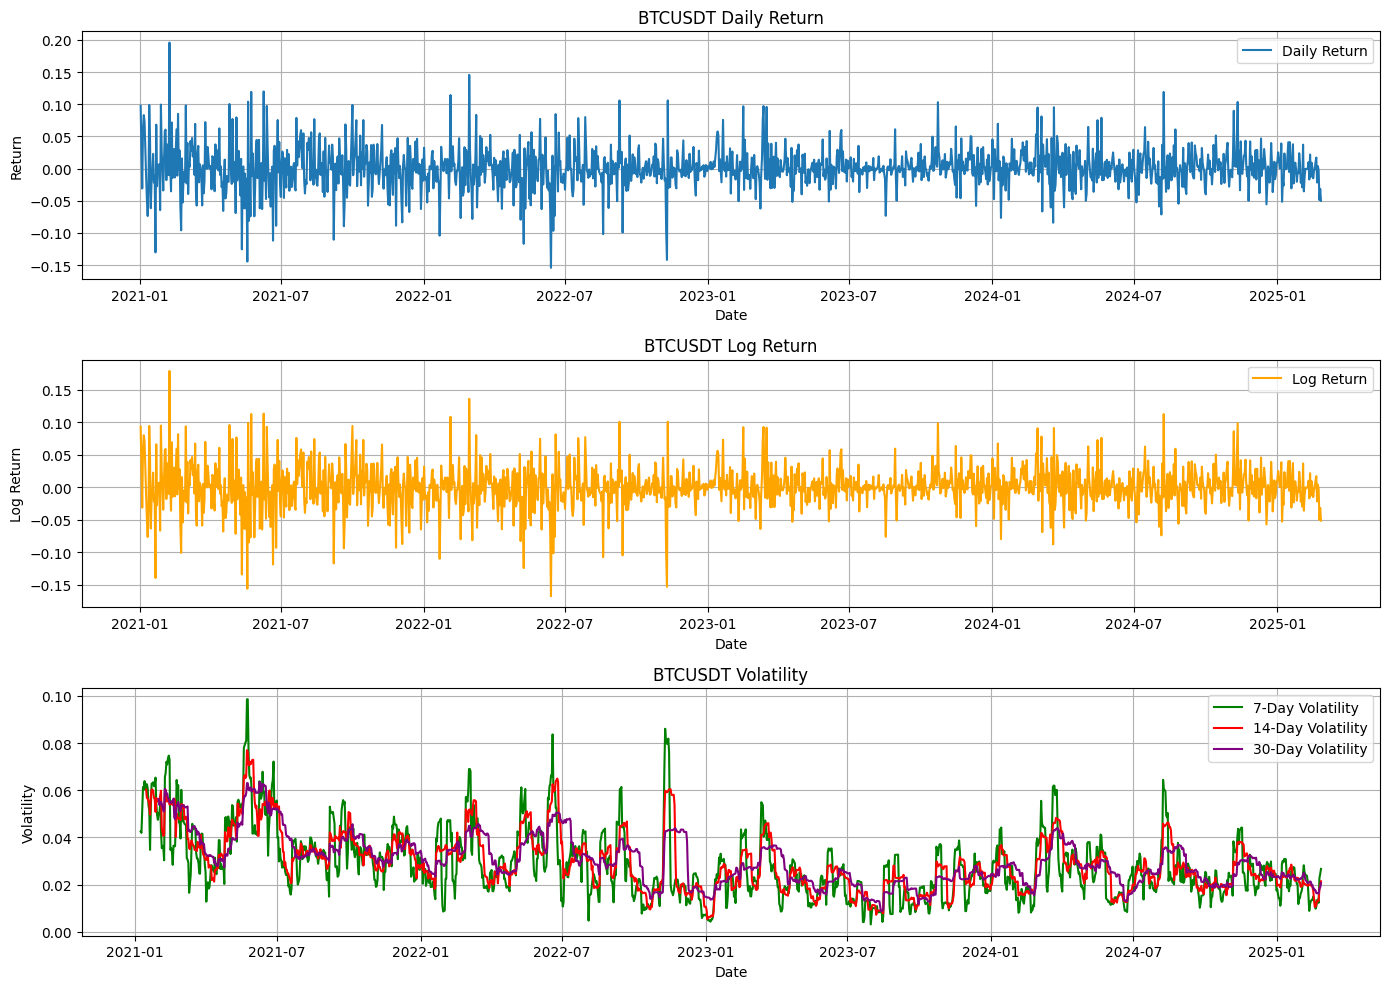

In [49]:
def plot_returns_volatility(symbol_name):
    symbol_data = df[df['symbol'] == symbol_name].copy()
    
    plt.figure(figsize=(14, 10))
    
    # 每日收益率
    plt.subplot(3, 1, 1)
    plt.plot(symbol_data['open_time'], symbol_data['daily_return'], label='Daily Return')
    plt.title(f'{symbol_name} Daily Return')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    
    # 對數收益率
    plt.subplot(3, 1, 2)
    plt.plot(symbol_data['open_time'], symbol_data['log_return'], label='Log Return', color='orange')
    plt.title(f'{symbol_name} Log Return')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True)
    plt.legend()
    
    # 波動率
    plt.subplot(3, 1, 3)
    plt.plot(symbol_data['open_time'], symbol_data['volatility_7d'], label='7-Day Volatility', color='green')
    plt.plot(symbol_data['open_time'], symbol_data['volatility_14d'], label='14-Day Volatility', color='red')
    plt.plot(symbol_data['open_time'], symbol_data['volatility_30d'], label='30-Day Volatility', color='purple')
    plt.title(f'{symbol_name} Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# edit here to plot 
plot_returns_volatility('BTCUSDT')



In [50]:
df[df['symbol']== 'BTCUSDT'].head(10)

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,daily_return,log_return,volatility_14d,volatility_7d,volatility_30d
7590,BTCUSDT,2021-01-01,28948.19,29668.86,28627.12,29337.16,210716.398,6.157505e+09,1511793,101247.902,2.960176e+09,NaN,NaN,NaN,NaN,NaN
7591,BTCUSDT,2021-01-02,29337.15,33480.00,28958.24,32199.91,545541.080,1.712294e+10,3514545,273388.463,8.578965e+09,0.097581,0.093109,NaN,NaN,NaN
7592,BTCUSDT,2021-01-03,32198.41,34832.25,32000.02,33054.53,487486.989,1.638911e+10,3325307,238761.657,8.029366e+09,0.026541,0.026195,NaN,NaN,NaN
7593,BTCUSDT,2021-01-04,33053.93,33653.56,27800.00,32031.07,506128.023,1.587920e+10,3470951,242947.199,7.626163e+09,-0.030963,-0.031452,NaN,NaN,NaN
7594,BTCUSDT,2021-01-05,32029.55,34500.00,29900.00,33999.52,433720.833,1.395935e+10,3077140,214417.082,6.904990e+09,0.061454,0.059640,NaN,NaN,NaN
7595,BTCUSDT,2021-01-06,33999.51,37037.51,33356.46,36823.68,444019.830,1.551522e+10,3343780,221236.888,7.735681e+09,0.083065,0.079795,NaN,NaN,NaN
7596,BTCUSDT,2021-01-07,36825.77,40565.62,36337.36,39498.92,520147.908,1.995556e+10,3936708,257944.968,9.900486e+09,0.072650,0.070132,NaN,NaN,NaN
7597,BTCUSDT,2021-01-08,39498.32,42125.51,36539.77,40637.23,518080.826,2.066727e+10,4247011,254344.167,1.015287e+10,0.028819,0.028411,NaN,0.042482,NaN
7598,BTCUSDT,2021-01-09,40638.91,41539.88,38733.28,40136.04,260882.805,1.052052e+10,2489926,126105.315,5.086881e+09,-0.012333,-0.012410,NaN,0.041923,NaN
7599,BTCUSDT,2021-01-10,40136.05,41412.12,35268.00,38221.67,436759.048,1.702709e+10,3699058,211717.223,8.261996e+09,-0.047697,-0.048872,NaN,0.051910,NaN


Put in predictors ( features )
- vwap 
    - window 
- rsi 
    - window 
- MA 
    - window 1
    - window 2 
- ATR 
    - window 
- quitile factors 
    - 

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 按照 symbol 和時間排序
df = df.sort_values(['symbol', 'open_time'])

# 計算 VWAP (Volume-Weighted Average Price)
# 創建一個空的 DataFrame 來存儲最終結果
result_df = df.copy()
result_df['vwap'] = np.nan

# 計算每個加密貨幣的 typical price
df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3

# 對每個 symbol 單獨計算 VWAP
for symbol, group in df.groupby('symbol'):
    # 提取日期部分作為分組依據
    group['date'] = group['open_time'].dt.date
    
    # 計算每個日期內的累積值
    group['tp_vol'] = group['typical_price'] * group['volume']
    
    # 對每個日期分別計算 VWAP
    for date, date_group in group.groupby('date'):
        # 計算累積值
        date_group['cum_tp_vol'] = date_group['tp_vol'].cumsum()
        date_group['cum_vol'] = date_group['volume'].cumsum()
        
        # 計算 VWAP
        date_group['vwap'] = date_group['cum_tp_vol'] / date_group['cum_vol']
        
        # 更新原始 DataFrame
        result_df.loc[date_group.index, 'vwap'] = date_group['vwap']

# 將計算結果賦值回 df
df = result_df

# 顯示結果
print("前 10 行資料 (包含 VWAP):")
print(df[['symbol', 'open_time', 'close', 'volume', 'vwap']].head(10))

# 檢查各 symbol 的 VWAP 計算
vwap_check = df.groupby('symbol')['vwap'].agg(['min', 'max', 'mean'])
print("\n各加密貨幣的 VWAP 統計:")
print(vwap_check)



# 可選：添加 VWAP 與收盤價差距的計算
# df['vwap_close_diff'] = ((df['close'] - df['vwap']) / df['vwap']) * 100  # 差距百分比

前 10 行資料 (包含 VWAP):
     symbol  open_time    close     volume        vwap
0  AAVEUSDT 2021-01-01   90.909   368132.6   88.853667
1  AAVEUSDT 2021-01-02   85.888   350675.1   86.887000
2  AAVEUSDT 2021-01-03   94.185   490412.4   90.401000
3  AAVEUSDT 2021-01-04  114.322  1108493.1  105.281333
4  AAVEUSDT 2021-01-05  119.800   843809.1  114.244000
5  AAVEUSDT 2021-01-06  115.719   485974.6  114.866000
6  AAVEUSDT 2021-01-07  115.235   726395.4  117.745000
7  AAVEUSDT 2021-01-08  110.686   523636.3  110.322000
8  AAVEUSDT 2021-01-09  117.674   346692.4  114.428000
9  AAVEUSDT 2021-01-10  126.987   684657.4  125.019667

各加密貨幣的 VWAP 統計:
                    min            max          mean
symbol                                              
AAVEUSDT      50.310000     619.030000    165.385693
ADAUSDT        0.176753       2.968367      0.757949
AVAXUSDT       3.515833     135.298333     33.214235
BCHUSDT       93.353333    1466.670000    345.753129
BNBUSDT       37.959000     752.043333  

In [ ]:
# 繪製 VWAP 與價格的比較圖
def plot_price_vs_vwap(symbol_name):
    symbol_data = df[df['symbol'] == symbol_name].copy()
    
    plt.figure(figsize=(12, 6))
    plt.plot(symbol_data['open_time'], symbol_data['close'], label='Close Price', color='blue')
    plt.plot(symbol_data['open_time'], symbol_data['vwap'], label='VWAP', color='red', linestyle='--')
    plt.title(f'{symbol_name} - Price vs VWAP')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 如果想為特定的加密貨幣繪製 VWAP 圖表，取消下面的注釋
# 例如，為 AAVEUSDT 繪製圖表
# plot_price_vs_vwap('AAVEUSDT')